# Lab 4 Report: 
## Surpass Human Performance in Fashion MNIST Classificaion

### Name:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [ ]:
Image('lab4_exercise.png', width = 1000)

## Prepare Data

In [ ]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy') 
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets 
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


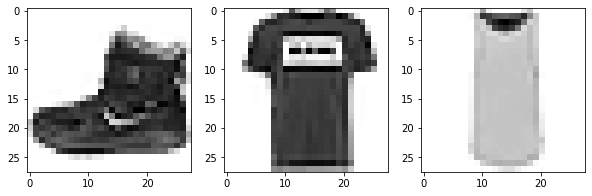

In [ ]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [ ]:
# Perform standard scaling on the training and testing features
# After scaling, make sure you reshape the training features back to (10000, 28, 28) and testing features to (1000, 28, 28)
# since CNNs take 2D tensors as inputs
scaler = StandardScaler()

train_features_flat = train_features.reshape(10000, 28*28) #reshape from 3d to 2d by taking square of 28
test_features_flat = test_features.reshape(1000, 28*28)
print(train_features_flat.shape)
print(test_features_flat.shape)

train_features = scaler.fit_transform(train_features_flat).reshape(10000, 28, 28)
test_features = scaler.fit_transform(test_features_flat).reshape(1000, 28, 28)

print(train_features.shape)
print(test_features.shape)

(10000, 784)
(1000, 784)
(10000, 28, 28)
(1000, 28, 28)


In [ ]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set 

validation_features = train_features[:1000]
validation_targets = train_targets[:1000]

# Take the remaining 9000 training features and targets as training set 

train_features = train_features[1000:]
train_targets = train_targets[1000:]

In [ ]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features = np.reshape(train_features, (9000, 1, 28, 28))
validation_features = np.reshape(validation_features, (1000, 1, 28, 28))
test_features = np.reshape(test_features, (1000, 1, 28, 28))

## Define Model

In [ ]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):
    
    def __init__(self):
        
        super(CNNModel, self).__init__()
        
        # First convolution layer (1 channel -> 16 channels, preserve original dimension by adding padding = 0)
        self.cnn1 = torch.nn.Conv2d(in_channels=1, out_channels=16, 
                              kernel_size=3, stride=1, padding=3)
        
        # First max pooling layer with kernel size = 3
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=3)
         
        # Second convolution layer (16 channel -> 32 channels, preserve dimension by adding padding = 0)
        self.cnn2 = torch.nn.Conv2d(in_channels=16, out_channels=32, 
                              kernel_size=3, stride=1, padding=3)
        
        # Second max pooling layer with kernel size = 3
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=3)
        
        # Fully connected layer that takes the flattened output of maxpool2 (32, 5 ,5) -> (800) and output 10 classes
        self.fc1 = torch.nn.Linear(32 * 4 * 4, 10) 
    
    def forward(self, x):
        
        # YOUR CODE HERE
        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput 
        # since it's incorporated within the loss function

        # input image -> conv1 -> relu -> maxpool1
        conv1_out = torch.nn.functional.relu(self.cnn1(x))       
        pool1_out = self.maxpool1(conv1_out)
        
        # maxpool1 output -> conv2 -> relu -> maxpool2
        conv2_out = torch.nn.functional.relu(self.cnn2(pool1_out))    
        pool2_out = self.maxpool2(conv2_out)

        #print(pool2_out.size())
        
        # flatten the maxpool2 output to be used as input into FCN layer
        fcn_input = pool2_out.view(pool2_out.size(0), -1)
    
        # Use the raw output of the fully connected layer as the final output
        output = self.fc1(fcn_input)
        
        return output

## Select Hyperparameters

In [ ]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

# Initialize your CNN model

model = CNNModel()

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 0.003
epochs = 30
batchsize = 420

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

model

CNNModel(
  (cnn1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (maxpool1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3))
  (maxpool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=10, bias=True)
)

## Identify Tracked Values

In [ ]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = []
validation_accuracy_list = np.zeros((epochs,))

## Train Model

In [ ]:
import tqdm # Use "for epoch in tqdm.trange(epochs):" to see the progress bar

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(train_features).float()
train_targets = torch.from_numpy(train_targets).long()

validation_inputs = torch.from_numpy(validation_features).float()
validation_targets = torch.from_numpy(validation_targets).long()

testing_inputs = torch.from_numpy(test_features).float()
testing_targets = torch.from_numpy(test_targets).long()

# Use torch.split() function to split the training inputs/targets into mini-batches
# See documentation of torch.split() https://pytorch.org/docs/stable/generated/torch.split.html
train_batches_features = torch.split(train_inputs, batchsize)
train_batches_targets = torch.split(train_targets, batchsize)

# length of train_batches_features = total number of mini-batches in the training set
batch_split_num = len(train_batches_features)
# Training Loop ---------------------------------------------------------------------------------------

for epoch in range(epochs):
    
        
    for k in range(batch_split_num):
    
        optimizer.zero_grad()
    
        train_batch_outputs = model(train_batches_features[k])

        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        train_loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

        with torch.no_grad():

          validation_outputs = model(validation_inputs)

          correct = (torch.argmax(validation_outputs, dim=1) == 
                   validation_targets).type(torch.FloatTensor)
        
          print("Epoch: "+ str(epoch), 
              "Validation Accuracy: " + str(np.round(correct.mean().numpy() * 100, 2)) + '%', flush=True)

          validation_accuracy_list[epoch] = correct.mean()


Epoch: 0 Validation Accuracy: 24.5%
Epoch: 0 Validation Accuracy: 43.2%
Epoch: 0 Validation Accuracy: 60.1%
Epoch: 0 Validation Accuracy: 59.7%
Epoch: 0 Validation Accuracy: 56.4%
Epoch: 0 Validation Accuracy: 62.9%
Epoch: 0 Validation Accuracy: 60.2%
Epoch: 0 Validation Accuracy: 67.5%
Epoch: 0 Validation Accuracy: 63.4%
Epoch: 0 Validation Accuracy: 66.9%
Epoch: 0 Validation Accuracy: 67.8%
Epoch: 0 Validation Accuracy: 69.4%
Epoch: 0 Validation Accuracy: 69.7%
Epoch: 0 Validation Accuracy: 73.0%
Epoch: 0 Validation Accuracy: 72.3%
Epoch: 0 Validation Accuracy: 72.2%
Epoch: 0 Validation Accuracy: 75.3%
Epoch: 0 Validation Accuracy: 75.2%
Epoch: 1 Validation Accuracy: 74.4%
Epoch: 1 Validation Accuracy: 76.1%
Epoch: 1 Validation Accuracy: 76.4%
Epoch: 1 Validation Accuracy: 75.5%
Epoch: 1 Validation Accuracy: 72.7%
Epoch: 1 Validation Accuracy: 75.9%
Epoch: 1 Validation Accuracy: 79.8%
Epoch: 1 Validation Accuracy: 76.9%
Epoch: 1 Validation Accuracy: 76.2%
Epoch: 1 Validation Accuracy

## Visualize & Evaluate Model

In [ ]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

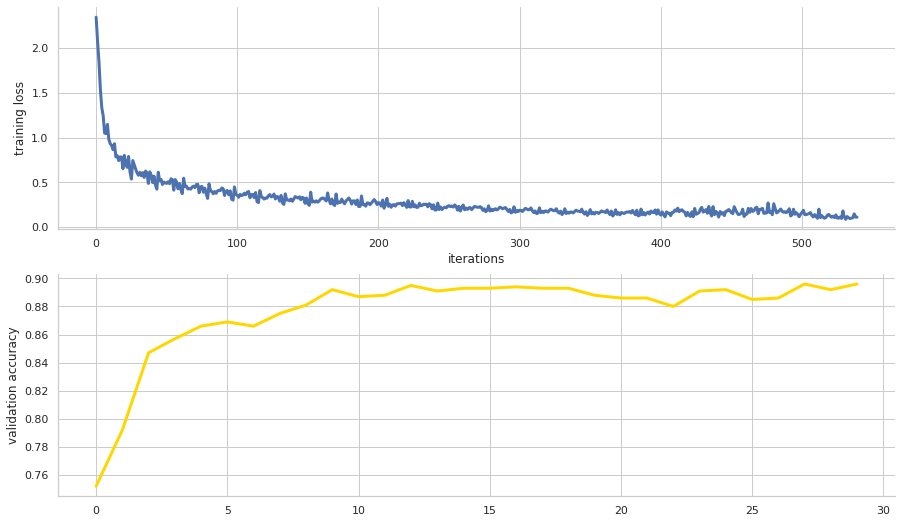

In [ ]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
sns.despine()

In [ ]:
# Compute the testing accuracy 

with torch.no_grad():
    
    y_pred_test = model(testing_inputs)
     
    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)
    
    print("Testing Accuracy: " + str(correct.mean().numpy()))

Testing Accuracy: 0.89


In [ ]:
# (OPTIONAL) Print the testing accuracy for each fashion class. Your code should produce something that looks like:
# Clever usage of np.where() could be useful here

# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...

# What's the fashion item that your model had the hardest time classifying?

# YOUR CODE HERE